In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Architecture

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channel_img, feature_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(feature_d, feature_d*2, 4, 2, 1),
            self._block(feature_d*2, feature_d*4, 4, 2, 1),
            self._block(feature_d*4, feature_d*8, 4, 2, 1),
            nn.Conv2d(feature_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)
    
    

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channel_img, feature_g): # z -> latent vector or noise
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, 1024, 4, 1, 0),
            self._block(1024, 512, 4, 2, 1),
            self._block(512, 256, 4, 2, 1),
            self._block(256, 128, 4, 2, 1),
            nn.ConvTranspose2d(128, channel_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    

    def forward(self, x):
        return self.gen(x)

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


## Data Preparation

In [6]:
LEARNING_RATE = 2e-4 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 128
FEATURES_GEN = 64
WORKERS = 4

In [7]:
BASE_DIR = "/home/jovyan/work/workspace/GAN-face-gen/"
IMAGE_DIR = "/home/jovyan/work/workspace/GAN-face-gen/data/face-images/"
# PARTITION_FILE = "/home/jovyan/work/workspace/GAN-face-gen/data/list_eval_partition.csv"
SPLIT_FILE = "/home/jovyan/work/workspace/GAN-face-gen/data/valid_split.csv"

In [8]:
partition_file = pd.read_csv(SPLIT_FILE)

train_df = partition_file[partition_file['Split'] == 0]
val_df = partition_file[partition_file['Split'] == 1]
test_df = partition_file[partition_file['Split'] == 2]

In [9]:
image_files = os.listdir(IMAGE_DIR)
image_files = [f for f in image_files if f.endswith(('.jpg', '.png'))]


In [10]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, data, transform=None):
        self.img_dir = img_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)


In [12]:
train_loader = DataLoader(
    FaceDataset(IMAGE_DIR, train_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

val_loader = DataLoader(
    FaceDataset(IMAGE_DIR, val_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

test_loader = DataLoader(
    FaceDataset(IMAGE_DIR, test_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

In [13]:
# def denormalize(img):
#     means = torch.tensor(normalise_means).view(3, 1, 1)
#     stds = torch.tensor(normalise_stds).view(3, 1, 1)
#     return img * stds + means

## Train

In [19]:
# model

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)


In [20]:
optimize_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimize_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()
schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimize_gen, NUM_EPOCHS, eta_min=0, last_epoch=-1)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optimize_disc, NUM_EPOCHS, eta_min=0, last_epoch=-1)

In [21]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step=0

In [22]:

def train():
    step =0
    all_lossD = []
    all_lossG = []
    for epoch in range(NUM_EPOCHS):
        total_lossD = 0
        total_lossG = 0
        print("\nEpoch : ", epoch+1)
        gen.train()
        disc.train()
        for idx, image in tqdm(enumerate(train_loader), total=len(train_loader), unit="batch", desc="Training"):
            image = image.to(device)
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

            fake = gen(noise)

            # Training Discriminator
            disc_real = disc(image).reshape(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake).reshape(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            optimize_disc.step()

            # Training Generator
            output = disc(fake).reshape(-1)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            lossG.backward()
            optimize_gen.step()

            total_lossD += lossD.item()
            total_lossG += lossG.item()

            if idx % 100 == 0:

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    img_grid_real = make_grid(image[:16], normalize=True)
                    img_grid_fake = make_grid(fake[:16], normalize=True)
                    writer_real.add_image("Real", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1

        schedulerG.step()


        all_lossD.append(total_lossD/len(train_loader))
        all_lossG.append(total_lossG/len(train_loader))
        
        # Validation
        # gen.eval()
        # disc.eval()

        # total_val_lossD = 0
        total_val_lossG = 0

        # for idx, image in tqdm(enumerate(val_loader), total=len(val_loader), unit="batch", desc="Validation", leave=True):
            

        print(f"Loss D: {total_lossD/len(train_loader):.4f}, loss G: {total_lossG/len(train_loader):.4f}\n")

In [23]:
train()


Epoch :  1


Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.4358, loss G: 2.7452


Epoch :  2



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.3856, loss G: 3.0491


Epoch :  3



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.3909, loss G: 2.5792


Epoch :  4



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.3998, loss G: 2.4416


Epoch :  5



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.3972, loss G: 2.3926


Epoch :  6



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.3748, loss G: 2.4567


Epoch :  7



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.3555, loss G: 2.5986


Epoch :  8



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.3297, loss G: 2.7049


Epoch :  9



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.3019, loss G: 2.8931


Epoch :  10



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.2790, loss G: 3.0380


Epoch :  11



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.2508, loss G: 3.2193


Epoch :  12



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.2253, loss G: 3.4291


Epoch :  13



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.2491, loss G: 3.4370


Epoch :  14



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.2028, loss G: 3.6514


Epoch :  15



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.1953, loss G: 3.7945


Epoch :  16



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.1973, loss G: 3.8378


Epoch :  17



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.1788, loss G: 3.9387


Epoch :  18



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.1659, loss G: 4.1578


Epoch :  19



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1512, loss G: 4.2304


Epoch :  20



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1330, loss G: 4.3541


Epoch :  21



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.1545, loss G: 4.4060


Epoch :  22



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1478, loss G: 4.3326


Epoch :  23



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1414, loss G: 4.5378


Epoch :  24



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.1199, loss G: 4.6596


Epoch :  25



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.1416, loss G: 4.6263


Epoch :  26



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1139, loss G: 4.7732


Epoch :  27



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1144, loss G: 4.8950


Epoch :  28



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.1052, loss G: 5.0669


Epoch :  29



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0945, loss G: 5.1579


Epoch :  30



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1088, loss G: 5.2161


Epoch :  31



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.0830, loss G: 5.2536


Epoch :  32



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.1267, loss G: 4.9287


Epoch :  33



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.0503, loss G: 5.5363


Epoch :  34



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1287, loss G: 5.2304


Epoch :  35



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.0617, loss G: 5.6668


Epoch :  36



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.1371, loss G: 4.9369


Epoch :  37



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0450, loss G: 6.2779


Epoch :  38



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.0833, loss G: 5.7022


Epoch :  39



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0981, loss G: 5.5255


Epoch :  40



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.0522, loss G: 6.0680


Epoch :  41



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0537, loss G: 6.0071


Epoch :  42



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.1224, loss G: 6.1565


Epoch :  43



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.0662, loss G: 5.7975


Epoch :  44



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0232, loss G: 6.6755


Epoch :  45



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0739, loss G: 6.9862


Epoch :  46



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.11batch/s]

Loss D: 0.0890, loss G: 6.1907


Epoch :  47



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.09batch/s]

Loss D: 0.0474, loss G: 7.0805


Epoch :  48



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0856, loss G: 7.1614


Epoch :  49



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.12batch/s]

Loss D: 0.0044, loss G: 8.1657


Epoch :  50



Training: 100%|██████████| 1128/1128 [01:33<00:00, 12.10batch/s]

Loss D: 0.0002, loss G: 10.3704



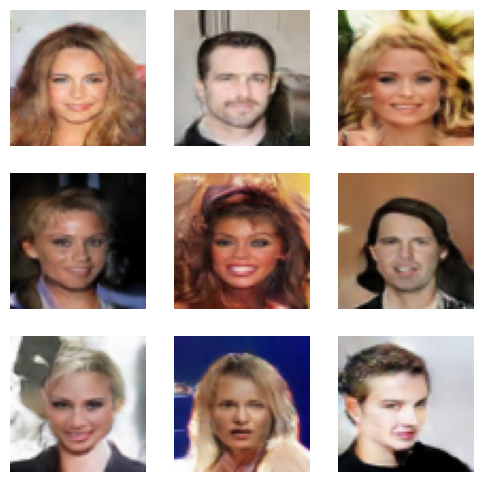

In [43]:
def denormalization(img):
    img = img / 2 + 0.5
    return img.clamp(0, 1)
gen.eval()
image_rows = 3
cols=3
noise = torch.randn(image_rows*cols, NOISE_DIM, 1, 1).to(device)
fake = gen(noise)

fig, axes = plt.subplots(image_rows, cols, figsize=(cols*2, image_rows*2))
for j in range(image_rows):
    for k in range(cols):
        fake_img = fake[j*cols+k].cpu().detach().permute(1, 2, 0).squeeze()
        # print(fake_img.shape)
        axes[j][k].imshow(denormalization(fake_img))
        axes[j][k].axis('off')
plt.show()


In [41]:
torch.save(gen.state_dict(), '../models/face-gen-50e-1.pth')